In [1]:
# %pip install --user sympy==1.12.1
# %conda activate NLP_practice
# %pip install sympy==1.12.1
# import sympy
# print(sympy.__version__)

In [2]:
%pip install torch==2.5.1 torchvision==0.20.1 torchaudio==2.5.1 numpy==1.24.1 --ignore-installed --user --index-url https://download.pytorch.org/whl/cu124


Looking in indexes: https://download.pytorch.org/whl/cu124
  Using cached https://download.pytorch.org/whl/cu124/torch-2.5.1%2Bcu124-cp310-cp310-win_amd64.whl (2510.7 MB)
  Using cached https://download.pytorch.org/whl/cu124/torchvision-0.20.1%2Bcu124-cp310-cp310-win_amd64.whl (6.1 MB)
  Using cached https://download.pytorch.org/whl/cu124/torchaudio-2.5.1%2Bcu124-cp310-cp310-win_amd64.whl (4.1 MB)
  Using cached https://download.pytorch.org/whl/numpy-1.24.1-cp310-cp310-win_amd64.whl (14.8 MB)
  Using cached https://download.pytorch.org/whl/filelock-3.13.1-py3-none-any.whl.metadata (2.8 kB)
  Using cached https://download.pytorch.org/whl/typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
  Using cached https://download.pytorch.org/whl/networkx-3.3-py3-none-any.whl.metadata (5.1 kB)
  Using cached https://download.pytorch.org/whl/Jinja2-3.1.4-py3-none-any.whl.metadata (2.6 kB)
  Using cached https://download.pytorch.org/whl/fsspec-2024.6.1-py3-none-any.whl.metadata (11 kB)
  Usi

In [3]:
import torch
import torch.optim as optim

import torch.nn as nn
import torch.nn.functional as F

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU name: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU name: NVIDIA GeForce RTX 3060 Ti


In [5]:
def check_memory():
    allocated = torch.cuda.memory_allocated() / 1e9  # GB
    reserved = torch.cuda.memory_reserved() / 1e9  # GB
    print(f"Allocated: {allocated:.2f} GB, Reserved: {reserved:.2f} GB")


check_memory()

Allocated: 0.00 GB, Reserved: 0.00 GB


In [6]:
import numpy as np
print(f"numpy version: {np.__version__}")
%pip install datasets


numpy version: 1.24.1
Note: you may need to restart the kernel to use updated packages.


In [7]:
from datasets import load_dataset
dataset = load_dataset("ag_news")
print(dataset)

print(dataset["train"][1])

c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})
{'text': 'Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\\which has a reputation for making well-timed and occasionally\\controversial plays in the defense industry, has quietly placed\\its bets on another part of the market.', 'label': 2}


In [8]:
%pip install transformers==4.47.1


In [9]:
%pip install scikit-learn



In [10]:
from sklearn.model_selection import train_test_split


def preprocess_agnews(
    train_size: float = 0.8,
    random_state: int = 42,
):

    dataset = load_dataset("ag_news")

    train_dataset = dataset["train"]
    test_dataset = dataset["test"]

    train_text = train_dataset["text"]
    train_labels = train_dataset["label"]

    train_text, val_text, train_label, val_label = train_test_split(
        train_text, train_labels, train_size=train_size, random_state=random_state
    )

    return train_text, train_label, val_text, val_label


class AGNewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels, texts):
        self.encodings = encodings
        self.labels = labels
        self.texts = texts
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        item['texts'] = self.texts[idx]
        return item

    def __len__(self):
        return len(self.labels)



In [11]:
train_text, train_label, val_text, val_label= preprocess_agnews()
print(f"Train samples: {len(train_text)}, Test samples: {len(val_text)}")

Train samples: 96000, Test samples: 24000


In [12]:
# import re
# def clean_text(text):
#     text = text.lower()
#     text = re.sub(r"<.*?>", "", text)
#     text = re.sub(r"http\S+|www\S+", "", text)
#     text = re.sub(r"\S+@\S+", "", text)
#     text = re.sub(r"[^a-z0-9\s@#\$!\?]", "", text)
#     text = re.sub(r"\s+", " ", text).strip()
#     return text

# train_text = [clean_text(t) for t in train_text]
# val_text = [clean_text(t) for t in val_text]

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import chi2
vectorizer = CountVectorizer(stop_words="english")
X = vectorizer.fit_transform(train_text)
chi2_scores, _ = chi2(X, train_label)
top_indices = np.argsort(chi2_scores)[::-1][:100]
top_keywords = [vectorizer.get_feature_names_out()[i] for i in top_indices]
def add_keyword_hint(text):
    related = [kw for kw in top_keywords if kw in text.lower()]
    hint = f"Important words: {' '.join(related)}. Headline: "
    return hint + text

train_text = [add_keyword_hint(text) for text in train_text]
val_text = [add_keyword_hint(text) for text in val_text]

In [14]:
from torch.utils.data import DataLoader
from transformers import AutoTokenizer
num_labels = len(set(train_label))
max_length = 128
batch_size = 16
test_batch_size = 64

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
train_encodings = tokenizer(
    train_text, truncation=True, padding=True, max_length=max_length
)
val_encodings = tokenizer(
    val_text, truncation=True, padding=True, max_length=max_length
)

train_dataset = AGNewsDataset(train_encodings, train_label, train_text)
val_dataset = AGNewsDataset(val_encodings, val_label, val_text)

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
val_loader = DataLoader(
    val_dataset, batch_size=test_batch_size, shuffle=False
)


In [15]:
import torch
import torch.nn as nn

class NLP_LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers, output_size):
        super(NLP_LSTM, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.embedding(x)
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])  
        out = self.fc(out)
        return out


In [16]:
class BiLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers, output_size):
        super(BiLSTM, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers, batch_first=True, bidirectional=True)

        self.dropout = nn.Dropout(0.5)
        self.attention = nn.Linear(hidden_size * 2, 1)
        self.softmax = nn.Softmax(dim=1)

        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        x = self.embedding(x)
        lstm_out, _  = self.lstm(x)
        attn_weight = self.attention(lstm_out).squeeze(2)
        attn_weight = self.softmax(attn_weight)

        attn_output = torch.sum(lstm_out * attn_weight.unsqueeze(2), dim=1)

        attn_output = self.dropout(attn_output)
        output = self.fc(attn_output)

        return output


In [17]:
vocab_size = tokenizer.vocab_size
embedding_dim = 128 
hidden_size = 128  
num_layers = 2  
output_size = 4 

rank = 4
alpha = 8

# optimizer = AdamW(model.parameters(), lr=5e-5)
# 1: Transformer+FC, 2: bert+LSTM, 3: BiLSTM+Attention 4: Lora+Bert
test_model = 4

In [18]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
suppress_words = ['al', 'search', 'corp', 'new', 'said',  'internet', '39',
 'ap', 'company', 'headline', 'google', 'service', 'microsoft', 'technology', 
 'important', 'words', 'lt', 'com', 'company', 'com', 'reuters', 'quarter', 
  'new', 'york', 'billion', 'ap', 'software', 'service', 'google', 'gt', 
  'shares', 'online', 'peoplesoft', 'war', 'oracle', 'technology', 'internet', 
  'year', 'wireless']
suppress_ids = set()
for word in suppress_words:
    ids = tokenizer.encode(word, add_special_tokens=False)
    suppress_ids.update(ids)


In [19]:

# class LoRALinear(nn.Module):
#     def __init__(self, in_features, out_features, rank, alpha):
#         super().__init__()
#         self.rank = rank
#         self.alpha = alpha
#         self.scaling = self.alpha / self.rank
#         self.linear = nn.Linear(in_features, out_features)

#         self.lora_A = nn.Parameter(torch.randn(in_features, rank) * 0.01) 
#         self.lora_B = nn.Parameter(torch.randn(rank, out_features) * 0.01) 

#         self.linear.weight.requires_grad = False
#         self.linear.bias.requires_grad = False

#     def forward(self, x):
#         original_output = self.linear(x)
#         lora_adjustment = (x @ self.lora_A) @ self.lora_B * self.scaling
#         return original_output + lora_adjustment



In [20]:
import torch
import torch.nn as nn

class AttentionPool(nn.Module):
    def __init__(self, hidden_dim, suppress_ids=None):
        super().__init__()
        self.attn = nn.Linear(hidden_dim, 1)
        self.suppress_ids = suppress_ids 

    def forward(self, x, input_ids=None, mask=None, return_weights=False):
        scores = self.attn(x).squeeze(-1)  
        if input_ids is not None and self.suppress_ids is not None:
            penalty_mask = torch.zeros_like(scores) 
            for suppress_id in self.suppress_ids:
                penalty_mask += (input_ids == suppress_id).float() * -1e3
            scores = scores + penalty_mask  

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        weights = torch.softmax(scores, dim=1)
        output = torch.sum(x * weights.unsqueeze(-1), dim=1)

        if return_weights:
            return output, weights
        return output


In [21]:
# def apply_lora_to_bert(model, rank=8, alpha=16):
#     for name, module in model.named_modules():
#         if isinstance(module, nn.Linear) and ("query" in name or "value" in name): 
#             in_features = module.in_features
#             out_features = module.out_features
#             lora_layer = LoRALinear(in_features, out_features, rank=rank, alpha=alpha)
            
#             parent_module_name = ".".join(name.split(".")[:-1])
#             submodule_name = name.split(".")[-1] 
#             parent_module = model.get_submodule(parent_module_name)
#             setattr(parent_module, submodule_name, lora_layer)


#     for name, param in model.named_parameters():
#         if "lora" not in name:
#             param.requires_grad = False 

#     return model



In [22]:
import torch
import torch.nn as nn

class BertExtended(nn.Module):
    def __init__(self, model):
        super(BertExtended, self).__init__()
        self.bert = model
        self.dropout = nn.Dropout(0.3)
        self.linear1 = nn.Linear(768, 256)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(256, 4)
    def forward(self, input_ids, attention_mask=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output  # [batch_size, 768]
        x = self.dropout(pooled_output)
        x = self.relu(self.linear1(x))
        logits = self.linear2(x)
        return logits

In [23]:
class BertLSTM(nn.Module):
    def __init__(self, model):
        super(BertLSTM, self).__init__()
        self.bert = model
        self.dropout_bert = nn.Dropout(0.3)
        self.lstm = nn.LSTM(768, 128, num_layers=2, batch_first=True, bidirectional=True)
        self.dropout_lstm = nn.Dropout(0.3)
        self.classifier = nn.Linear(128 * 2, 4)
    def forward(self, input_ids, attention_mask=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        x = self.dropout_bert(outputs.last_hidden_state)
        x, _ = self.lstm(x)
        x = self.dropout_lstm(x[:, 0, :])
        logits = self.classifier(x)
        return logits

In [24]:
class BertTextCNN(nn.Module):
    def __init__(self, model):
        super(BertTextCNN, self).__init__()
        self.bert = model
        self.convs = nn.ModuleList([
            nn.Conv2d(1, 100, (k, 768)) for k in [2, 3, 4]
        ])
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(300, 4)
    def forward(self, input_ids, attention_mask=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        x = outputs.last_hidden_state.unsqueeze(1)
        conv_outs = []
        for conv in self.convs:
            c = F.relu(conv(x)).squeeze(3)
            p = F.max_pool1d(c, kernel_size=c.size(2)).squeeze(2)
            conv_outs.append(p)
        x = torch.cat(conv_outs, 1)
        x = self.dropout(x)
        logits = self.fc(x)
        return logits

In [ ]:

class BertResidualMLPClassifier(nn.Module):
    def __init__(self,model, suppress_ids=None):
        super(BertResidualMLPClassifier, self).__init__()
        self.bert = model
        # MLP block with residual connection
        # self.attn_pool = AttentionPool(768, suppress_ids=suppress_ids)
        self.mlp1 = nn.Linear(768, 768)  # Intermediate dimension
        self.relu1 = nn.ReLU()
        self.mlp2 = nn.Linear(768, 768)
        self.relu2 = nn.ReLU()
        # Classifier
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(768, 4)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        x = outputs.last_hidden_state[:,0,:]  # [B, L, 768]

        # pooled = self.attn_pool(x,input_ids=input_ids, mask=attention_mask)  # [B, 768]

        # Residual MLP block
        hidden = self.relu1(self.mlp1(x))
        residual = self.relu2(self.mlp2(hidden)+x)

        logits = self.classifier(self.dropout(residual))
        return logits


In [26]:
from transformers import AutoModelForSequenceClassification
from transformers import BertModel

bert = BertModel.from_pretrained("bert-base-uncased")
model1 = BertExtended(bert)
# model4 = apply_lora_to_bert(model1,rank=rank, alpha=alpha)

# model2 = NLP_LSTM(vocab_size, embedding_dim, hidden_size, num_layers, output_size)
model2 = BertLSTM(bert)

# model3 = BiLSTM(vocab_size, embedding_dim, hidden_size, num_layers, output_size)
model3 = BertTextCNN(bert)

model4 = BertResidualMLPClassifier(bert, suppress_ids=suppress_ids)

model1 = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=4,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
match test_model:
    case 1:
        model = model1
        optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
    case 2:
        model = model2
        optimizer = torch.optim.Adam([
            {'params': model.bert.parameters(), 'lr': 2e-5},
            {'params': model.lstm.parameters(), 'lr': 1e-3},
            {'params': model.classifier.parameters(), 'lr': 1e-3}
        ])

    case 3:
        model = model3
        optimizer = torch.optim.Adam([
            {'params': model.bert.parameters(), 'lr': 2e-5},
            {'params': model.convs.parameters(), 'lr': 1e-3},
            {'params': model.fc.parameters(), 'lr': 1e-3},
        ])
    case 4:
        model = model4
        optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)


model = model.to(device)
criterion = nn.CrossEntropyLoss()

if(test_model == 1):
    print("bert")
elif(test_model == 2):
    print("bert+LSTM")
elif(test_model == 3):
    print("bert+CNN")
elif(test_model == 4):
    print("bert+MLP")
else:
    print("model fussion")

bert+MLP


In [28]:
from tqdm import tqdm

torch.cuda.empty_cache()


num_epochs = 1
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        inputs = batch["input_ids"].to(device)
        labels = batch["labels"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        logits = model(inputs, attention_mask=attention_mask)
        loss = criterion(logits, labels)
            
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/3000:.4f}')

modelA = model

100%|██████████| 6000/6000 [29:11<00:00,  3.43it/s]

Epoch [1/1], Loss: 0.4780


In [29]:
from sklearn.metrics import accuracy_score

model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs
        preds = torch.argmax(logits, dim=-1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9349166666666666


In [30]:
# if(test_model == 5):
#     num_epochs = 1
#     modelB = model4
#     optimizer = torch.optim.Adam(modelB.parameters(), lr=0.001)
#     for epoch in range(num_epochs):
#         modelB.train()
#         total_loss = 0
#         for batch in tqdm(train_loader):
#             optimizer.zero_grad()
#             inputs = batch["input_ids"].to(device)
#             labels = batch["labels"].to(device)
#             if test_model >1 and test_model < 4:
#                 logits2 = modelB(inputs)
#                 loss2 = criterion(logits2, labels)
#             else: 
#                 attention_mask = batch["attention_mask"].to(device)
#                 logits2 = modelB(inputs, attention_mask=attention_mask, labels=labels)
#                 loss2 = logits2[0]
                
#             loss2.backward()
#             optimizer.step()
#             total_loss += loss2.item()

#         print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/3000:.4f}')

In [31]:
%pip install -q scikit-learn seaborn


Note: you may need to restart the kernel to use updated packages.


Classification Report:
               precision    recall  f1-score   support

       World       0.96      0.92      0.94      5956
      Sports       0.96      1.00      0.98      6058
    Business       0.93      0.87      0.90      5911
        Tech       0.89      0.95      0.92      6075

    accuracy                           0.93     24000
   macro avg       0.94      0.93      0.93     24000
weighted avg       0.94      0.93      0.93     24000



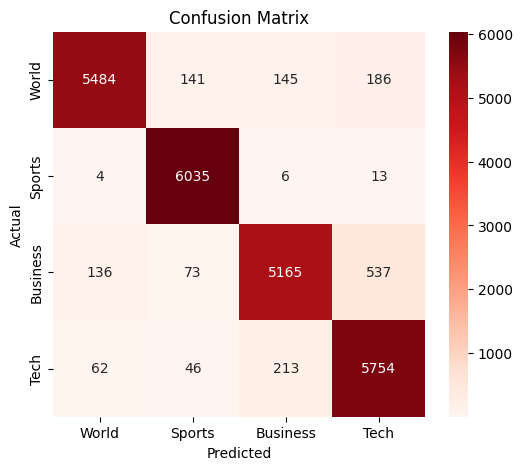

array([[5484,  141,  145,  186],
       [   4, 6035,    6,   13],
       [ 136,   73, 5165,  537],
       [  62,   46,  213, 5754]], dtype=int64)

In [32]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_confusion_matrix(model, dataloader, class_names, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())


    cm = confusion_matrix(all_labels, all_preds)
    print("Classification Report:\n", classification_report(all_labels, all_preds, target_names=class_names))


    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
                    xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    return cm

class_names = ["World", "Sports", "Business", "Tech"]
evaluate_confusion_matrix(model, val_loader, class_names, device)


In [33]:
def extract_cls_embeddings(model, dataloader, device):
    model.eval()
    embeddings, labels, preds, texts = [], [], [], []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            label = batch['labels'].to(device)
            raw_texts = batch['texts'] 

            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            pred = torch.argmax(logits, dim=1)

            outputs = model.bert(input_ids=input_ids, attention_mask=attention_mask)
            cls_vec = outputs.last_hidden_state[:, 0, :] 

            embeddings.append(cls_vec.cpu())
            preds.extend(pred.cpu().numpy())
            labels.extend(label.cpu().numpy())
            texts.extend(raw_texts)
            
    embeddings = torch.cat(embeddings).numpy()
    return embeddings, preds, labels, texts

import pandas as pd

def extract_misclassified(preds, labels, texts):
    misclassified = []
    for p, l, t in zip(preds, labels, texts):
        if p != l:
            misclassified.append({
                'true_label': l,
                'pred_label': p,
                'text': t
            })
    return pd.DataFrame(misclassified)

from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

def tfidf_diff(misclassified_df, target_pair=(2, 3), top_n=10):

    true_class = target_pair[0]
    pred_class = target_pair[1]

    mis_texts = misclassified_df[
        (misclassified_df['true_label'] == true_class) &
        (misclassified_df['pred_label'] == pred_class)
    ]['text'].tolist()

    tfidf = TfidfVectorizer(stop_words='english', max_features=1000)
    X = tfidf.fit_transform(mis_texts)

    avg_scores = np.asarray(X.mean(axis=0)).ravel()
    top_indices = avg_scores.argsort()[::-1][:top_n]
    top_words = [tfidf.get_feature_names_out()[i] for i in top_indices]

    return top_words

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

def plot_embeddings(embeddings, labels, method="tsne"):
    if method == "pca":
        reducer = PCA(n_components=2)
    else:
        reducer = TSNE(n_components=2, random_state=42, perplexity=40)

    reduced = reducer.fit_transform(embeddings)
    label_names = ["World", "Sports", "Business", "Sci/Tech"]
    label_colors = [label_names[l] for l in labels]

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], hue=label_colors, palette='deep')
    plt.title(f"[CLS] Embedding Visualization via {method.upper()}")
    plt.legend()
    plt.show()


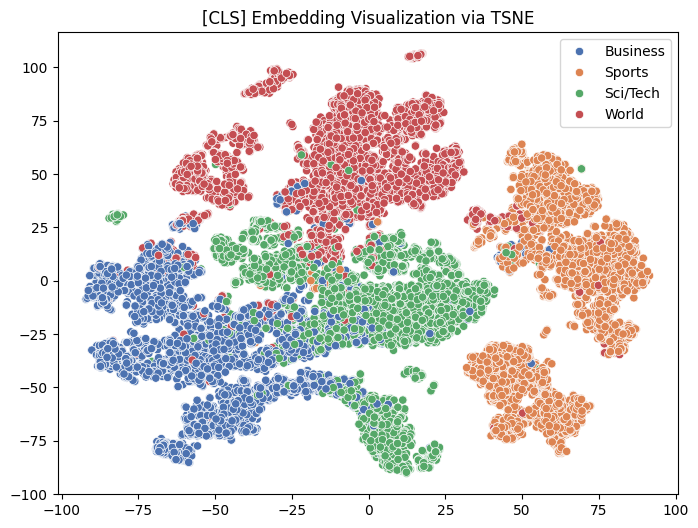

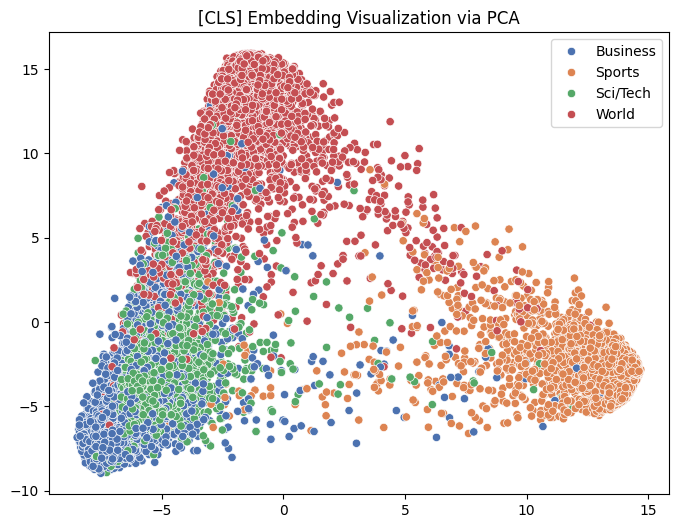

['important', 'headline', 'words', 'al', 'company', 'com', 'said', 'corp', '39', 'microsoft', 'peoplesoft', 'oracle', 'reuters', 'lt', 'shares', 'billion', 'new', 'ap', 'people', 'earnings', 'google', 'gt', 'quarter', 'profit', 'york', 'war', 'computer', 'stock', 'year', 'online']


In [34]:
embeddings, preds, labels, texts = extract_cls_embeddings(model, val_loader, device)
mis_df = extract_misclassified(preds, labels, texts)
label_names = ["World", "Sports", "Business", "Sci/Tech"]
wrong_words = tfidf_diff(mis_df, target_pair=(3, 2), top_n=30)

plot_embeddings(embeddings, labels, method="tsne")
plot_embeddings(embeddings, labels, method="pca")


print(wrong_words)



In [35]:
from sklearn.metrics import f1_score

def evaluate_macro_f1(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    macro_f1 = f1_score(all_labels, all_preds, average='macro')
    return macro_f1

macro_f1 = evaluate_macro_f1(model, val_loader, device)
print(f"Macro F1 Score: {macro_f1:.4f}")

Macro F1 Score: 0.9345


In [36]:
check_memory()
print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.5f}')

Allocated: 1.81 GB, Reserved: 3.15 GB
Epoch [1/1], Loss: 1434.06395


In [37]:
# def count_parameters(modelB):
#     total_params = sum(p.numel() for p in modelB.parameters())
#     trainable_params = sum(p.numel() for p in modelB.parameters() if p.requires_grad)
#     return total_params, trainable_params

# total_params, trainable_params = count_parameters(modelB)
# print(f"LoRA Fine-Tuning - Total Params: {total_params:,}, Trainable Params: {trainable_params:,}")

In [38]:
# def weight_vote(model1, model2, wight1, wight2):
#     probs = wight1 * model1 + wight2 * model2
#     preds = torch.argmax(probs, dim=1)
#     return preds



In [39]:
# from sklearn.metrics import accuracy_score

# # if(test_model<5):
# modelB.eval()
# all_preds = []
# all_labels = []
# with torch.no_grad():
#     for batch in val_loader:
#         input_ids = batch['input_ids'].to(device)
#         attention_mask = batch['attention_mask'].to(device)
#         labels = batch['labels'].to(device)
#         if test_model >1 and test_model < 4:
#             outputs = modelB(input_ids)
#             logits = outputs
#         else:
#             outputs = modelB(input_ids, attention_mask=attention_mask)
#             logits = outputs.logits
#         preds = torch.argmax(logits, dim=-1)

#         all_preds.extend(preds.cpu().numpy())
#         all_labels.extend(labels.cpu().numpy())

# accuracy = accuracy_score(all_labels, all_preds)
# print(f"Accuracy: {accuracy}")


In [40]:
# if(test_model == 5):
#     weight_modelA = 0.6
#     weight_modelB = 0.4

#     all_preds = []
#     all_labels = []

#     with torch.no_grad():
#         for batch in val_loader:
#             input_ids = batch['input_ids'].to(device)
#             attention_mask = batch['attention_mask'].to(device)
#             labels = batch['labels'].to(device)

#             outputs_A = modelA(input_ids)
#             probs_A = torch.nn.functional.softmax(outputs_A, dim=-1)

#             # outputs_B = modelB(input_ids)
#             # probs_B = torch.nn.functional.softmax(outputs_B, dim=-1)

#             outputs_B = modelB(input_ids, attention_mask=attention_mask)
#             probs_B = torch.nn.functional.softmax(outputs_B.logits, dim=-1)

#             final_probs = weight_modelA * probs_A + weight_modelB * probs_B
#             preds = torch.argmax(final_probs, dim=-1)

#             all_preds.extend(preds.cpu().numpy())
#             all_labels.extend(labels.cpu().numpy())

#     accuracy = accuracy_score(all_labels, all_preds)
#     print(f"Fused Model Accuracy: {accuracy:.4f}")

In [41]:
torch.cuda.empty_cache()  # 釋放 PyTorch 未使用的顯存
torch.cuda.ipc_collect()  # 進一步回收已刪除的張量

check_memory()

Allocated: 1.81 GB, Reserved: 2.06 GB


In [42]:
model.eval()
sample_text = "microsoft stock arise by 10% after the new product launch"
sample_tokens = tokenizer(sample_text, padding="max_length", truncation=True, max_length=32, return_tensors="pt")

sample_tokens = {key: value.to(device) for key, value in sample_tokens.items()}

y_pred = model(sample_tokens["input_ids"])
predicted_label = torch.argmax(y_pred, dim=1).item()

class_names = ["World News", "Sports", "Business", "Technology"]
print(f'Predicted Class: {class_names[predicted_label]}')


TypeError: BertResidualMLPClassifier.forward() missing 1 required positional argument: 'attention_mask'